<a href="https://colab.research.google.com/github/RahulKhandebharad/Data-Science-/blob/master/W2_1_1_EDA_with_Personal_Email_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1e5puJF18AZddSEDxycKGwf_Y7shAbwzQ?usp=sharing)

In [ ]:
#Let's load the required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
!pip install mailbox

In [ ]:
#When you have loaded the libraries, load the dataset:

import mailbox
mboxfile = "data.mbox"

mbox = mailbox.mbox(mboxfile)


In [ ]:
#let's see the list of available keys:mbox
for key in mbox[0].keys():
    print(key)

KeyError: ignored

In [ ]:
import csv
#create a CSV file with only the required attributes:
with open('mailbox.csv', 'w') as outputfile:
    writer = csv.writer(outputfile)
    writer.writerow(['subject','from','date','to','label','thread'])
    for message in mbox:
        writer.writerow([message['subject'], message['from'],  message['date'], message['to'],  message['X-Gmail-Labels'], message['X-GM-THRID']])

In [ ]:
dfs = pd.read_csv('mailbox.csv', names=['subject', 'from', 'date', 'to', 'label', 'thread'])

In [ ]:
#Check the datatypes
dfs.dtypes

subject    object
from       object
date       object
to         object
label      object
thread     object
dtype: object

In [ ]:
#Note that a date field is an object. 
#So, we need to convert it into a DateTime argument.
#we are going to convert the date field into an actual DateTime argument. We can do this by using the pandas to_datetime() method. 
dfs['date'] = dfs['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

In [ ]:
#remove NaN values from the field
dfs = dfs[dfs['date'].notna()]

In [ ]:
dfs.to_csv('gmail.csv')


# Applying descriptive statistics


In [ ]:
dfs.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   subject  0 non-null      object        
 1   from     0 non-null      object        
 2   date     0 non-null      datetime64[ns]
 3   to       0 non-null      object        
 4   label    0 non-null      object        
 5   thread   0 non-null      object        
dtypes: datetime64[ns](1), object(5)
memory usage: 0.0+ bytes


In [ ]:
dfs.head(10)

,subject,from,date,to,label,thread


In [ ]:
dfs.columns

Index(['subject', 'from', 'date', 'to', 'label', 'thread'], dtype='object')

In [ ]:
import re
# function that takes an entire string from any column and extracts an email address
def extract_email_ID(string):
  email = re.findall(r'<(.+?)>', string) #regular expression to find an email address
  if not email:
    email = list(filter(lambda y: '@' in y, string.split()))
  return email[0] if email else np.nan

In [ ]:
dfs['from'] = dfs['from'].apply(lambda x: extract_email_ID(x))

In [ ]:
#we are going to refactor the label field. The logic is simple. 
#If an email is from your email address, then it is the sent email. Otherwise, it is a received email, that is, an inbox email:
myemail = 'joinalahmed@gmail.com'
dfs['label'] = dfs['from'].apply(lambda x: 'sent' if x==myemail else 'inbox')

In [ ]:
dfs.drop(columns='to', inplace=True)

In [ ]:
dfs.head(10)

,subject,from,date,label,thread


In [ ]:
import datetime 
import pytz
#refactor timezones
def refactor_timezone(x):
  est = pytz.timezone('US/Eastern')
  return x.astimezone(est)

In [ ]:
dfs['date'] = dfs['date'].apply(lambda x: refactor_timezone(x))

In [ ]:
#convert the day of the week variable into the name of the day, as in, Saturday, Sunday, and so on.
dfs['dayofweek'] = dfs['date'].apply(lambda x: x.weekday_name)
dfs['dayofweek'] = pd.Categorical(dfs['dayofweek'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
    'Saturday', 'Sunday'], ordered=True)

In [ ]:
dfs['timeofday'] = dfs['date'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

In [ ]:
# refactor the hour, the year integer, and the year fraction, respectively. 
dfs['hour'] = dfs['date'].apply(lambda x: x.hour)

In [ ]:
dfs['year_int'] = dfs['date'].apply(lambda x: x.year)

In [ ]:
dfs['year'] = dfs['date'].apply(lambda x: x.year + x.dayofyear/365.25)

In [ ]:
dfs.index = dfs['date']
del dfs['date']

In [ ]:
#"How many emails did I send during a given timeframe?"
print(dfs.index.min().strftime('%a, %d %b %Y %I:%M %p'))
print(dfs.index.max().strftime('%a, %d %b %Y %I:%M %p'))

print(dfs['label'].value_counts())

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [ ]:
def plot_todo_vs_year(df, ax, color='C0', s=0.5, title=''):
  ind = np.zeros(len(df), dtype='bool')
  est = pytz.timezone('US/Eastern')
    
  df[~ind].plot.scatter('year', 'timeofday', s=s, alpha=0.6, ax=ax, color=color)
  ax.set_ylim(0, 24)
  ax.yaxis.set_major_locator(MaxNLocator(8))
  ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p") for ts in ax.get_yticks()]);

  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(title)
  ax.grid(ls=':', color='k')

  return ax

In [ ]:
#Let's create two sub-dataframe—one for sent emails and another for received emails:

sent = dfs[dfs['label']=='sent']
received = dfs[dfs['label']=='inbox']

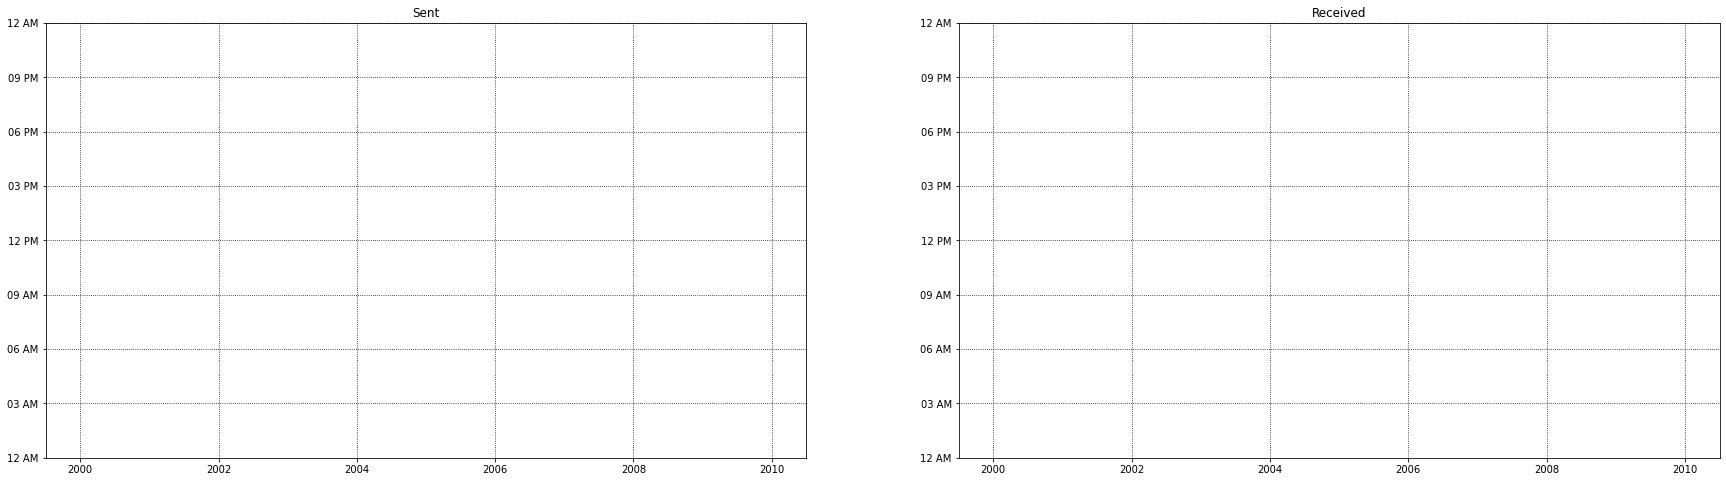

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 8))

plot_todo_vs_year(sent, ax[0], title='Sent')
plot_todo_vs_year(received, ax[1], title='Received')

The higher the density of the graph data points, the higher the number of emails. Note that the number of sent emails is less than the number of received emails. I received more emails than I sent from 2012 to 2020. Note that I received most of the emails between 03:00 PM and 03:00 AM. This graph gives a nice overview of the time of day of email activity. 

In [ ]:
def plot_number_perday_per_year(df, ax, label=None, dt=0.3, **plot_kwargs):
    year = df[df['year'].notna()]['year'].values
    T = year.max() - year.min()
    bins = int(T / dt)
    weights = 1 / (np.ones_like(year) * dt * 365.25)
    ax.hist(year, bins=bins, weights=weights, label=label, **plot_kwargs);
    ax.grid(ls=':', color='k')

In [ ]:
from scipy import ndimage

def plot_number_perdhour_per_year(df, ax, label=None, dt=1, smooth=False,
                      weight_fun=None, **plot_kwargs):

    tod = df[df['timeofday'].notna()]['timeofday'].values
    year = df[df['year'].notna()]['year'].values
    Ty = year.max() - year.min()
    T = tod.max() - tod.min()
    bins = int(T / dt)
    if weight_fun is None:
        weights = 1 / (np.ones_like(tod) * Ty * 365.25 / dt)
    else:
        weights = weight_fun(df)
    if smooth:
        hst, xedges = np.histogram(tod, bins=bins, weights=weights);
        x = np.delete(xedges, -1) + 0.5*(xedges[1] - xedges[0])
        hst = ndimage.gaussian_filter(hst, sigma=0.75)
        f = interp1d(x, hst, kind='cubic')
        x = np.linspace(x.min(), x.max(), 10000)
        hst = f(x)
        ax.plot(x, hst, label=label, **plot_kwargs)
    else:
        ax.hist(tod, bins=bins, weights=weights, label=label, **plot_kwargs);


    ax.grid(ls=':', color='k')
    orientation = plot_kwargs.get('orientation')
    if orientation is None or orientation == 'vertical':
        ax.set_xlim(0, 24)
        ax.xaxis.set_major_locator(MaxNLocator(8))
        ax.set_xticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                            for ts in ax.get_xticks()]);
    elif orientation == 'horizontal':
        ax.set_ylim(0, 24)
        ax.yaxis.set_major_locator(MaxNLocator(8))
        ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                            for ts in ax.get_yticks()]);



In [ ]:
class TriplePlot:
  def __init__(self):
    gs = gridspec.GridSpec(6, 6)
    self.ax1 = plt.subplot(gs[2:6, :4])
    self.ax2 = plt.subplot(gs[2:6, 4:6], sharey=self.ax1)
    plt.setp(self.ax2.get_yticklabels(), visible=False);
    self.ax3 = plt.subplot(gs[:2, :4])  
    plt.setp(self.ax3.get_xticklabels(), visible=False);

  def plot(self, df, color='darkblue', alpha=0.8, markersize=0.5, yr_bin=0.1, hr_bin=0.5):
    plot_todo_vs_year(df, self.ax1, color=color, s=markersize)
    plot_number_perdhour_per_year(df, self.ax2, dt=hr_bin, color=color, alpha=alpha, orientation='horizontal')
    self.ax2.set_xlabel('Average emails per hour')
    plot_number_perday_per_year(df, self.ax3, dt=yr_bin, color=color, alpha=alpha)
    self.ax3.set_ylabel('Average emails per day')

ValueError: ignored

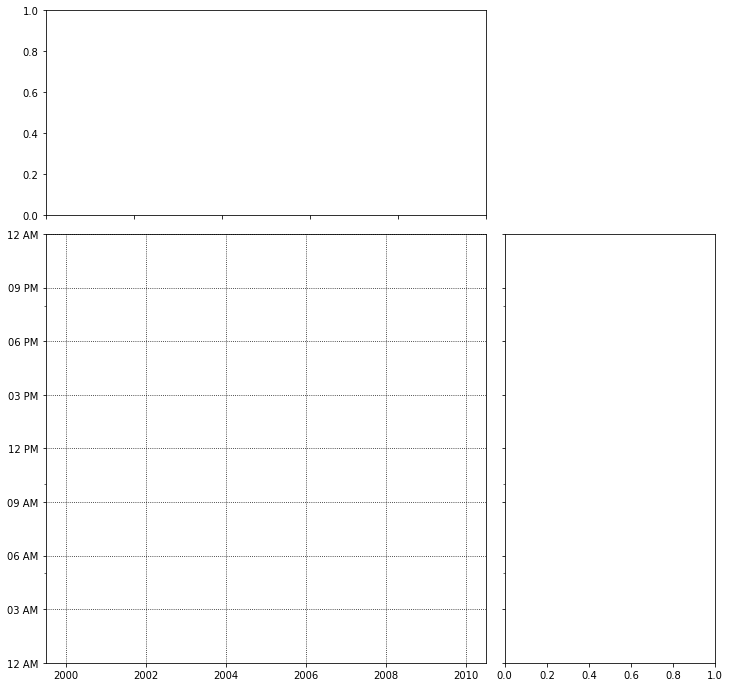

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

plt.figure(figsize=(12,12));
tpl = TriplePlot()

tpl.plot(received, color='C0', alpha=0.3)
tpl.plot(sent, color='C1', alpha=0.9)
p1 = mpatches.Patch(color='C0', label='Incoming', alpha=0.3)
p2 = mpatches.Patch(color='C1', label='Outgoing', alpha=0.9)
plt.legend(handles=[p1, p2], bbox_to_anchor=[1.45, 0.7], fontsize=36, shadow=True);

The average emails per hour and per graph is illustrated by the preceding graph. In my case, most email communication happened between 2018 and 2020. 

In [ ]:
counts = dfs.dayofweek.value_counts(sort=False)
counts.plot(kind='bar')

The preceding output shows that my busiest day is zmonday. I receive most of my emails on monday,tuesday. Lets go one step further and see the most active days for receiving and sending emails separately:

In [ ]:
addrs = received['from'].value_counts()

addrs[0:10]

In [ ]:
plt.figure(figsize=(12,12));

tpl = TriplePlot()

labels = []
colors = ['C{}'.format(ii) for ii in range(9)]
idx = np.array([1,2,3,7])
for ct, addr in enumerate(addrs.index[idx]):
    tpl.plot(dfs[dfs['from'] == addr], color=colors[ct], alpha=0.3, yr_bin=0.5, markersize=1.0)
    labels.append(mpatches.Patch(color=colors[ct], label=addrs[0:4], alpha=0.5))
plt.legend(handles=labels, bbox_to_anchor=[2.8, 0.2], fontsize=12, shadow=True);

In [ ]:
sdw = sent.groupby('dayofweek').size() / len(sent)
rdw = received.groupby('dayofweek').size() / len(received)

df_tmp = pd.DataFrame(data={'Outgoing Email': sdw, 'Incoming Email':rdw})
df_tmp.plot(kind='bar', rot=45, figsize=(8,5), alpha=0.5)
plt.xlabel('');
plt.ylabel('Fraction of weekly emails');
plt.grid(ls=':', color='k', alpha=0.5)

We can even go one level further. Let's find the most active time of day for email communication. We can do that easily. See the following code:

In [ ]:
import scipy.ndimage
from scipy.interpolate import interp1d

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
for ct, dow in enumerate(dfs.dayofweek.cat.categories):
    df_r = received[received['dayofweek']==dow]
    weights = np.ones(len(df_r)) / len(received)
    wfun = lambda x: weights
    plot_number_perdhour_per_year(df_r, ax, dt=1, smooth=True, color=f'C{ct}',
                      alpha=0.8, lw=3, label=dow, weight_fun=wfun)

    df_s = sent[sent['dayofweek']==dow]
    weights = np.ones(len(df_s)) / len(sent)
    wfun = lambda x: weights
    plot_number_perdhour_per_year(df_s, ax, dt=1, smooth=True, color=f'C{ct}',
                      alpha=0.8, lw=2, label=dow, ls='--', weight_fun=wfun)
ax.set_ylabel('Fraction of weekly emails per hour')
plt.legend(bbox_to_anchor=[1.8, 0.2], fontsize=12, shadow=True)


One of the easiest things to analyze about your emails is the most frequently used words. We can create a word cloud to see the most frequently used words. Let's first remove the archived emails:

In [ ]:
!pip install WordCloud

In [ ]:
from wordcloud import WordCloud 

text = ' '.join(map(str, dfs['subject'].values))

In [ ]:
stopwords = ['Re', 'Fwd', '3A_']
wrd = WordCloud(width=700, height=480, margin=0, collocations=False)
for sw in stopwords:
    wrd.stopwords.add(sw)
wordcloud = wrd.generate(text)

plt.figure(figsize=(25,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

This tells me what I mostly communicate about. From the analysis of emails from 2012 to 2020, the most frequently used words are Regarding, India, new, Data, job, and learning. This is really good, right? What is presented in this notebook is just a starting point. You can take this further in several other directions. 